In [1]:
import numpy as np
from os.path import expanduser
import pyret.filtertools as ft
import pyret.visualizations as viz
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib qt

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

In [4]:
weights_dir = expanduser('~/Dropbox/deep-retina/saved_models/2015-11-05 15.50.00 convnet/conv-lstm_weights_on_epoch.hdf5')

In [5]:
weights = h5py.File(weights_dir, 'r')

## Layers 0, 4, and 6 have weights

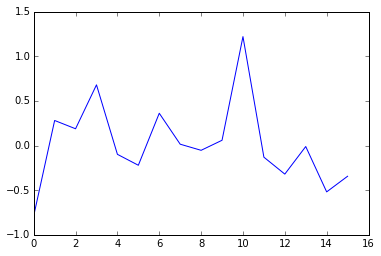

In [19]:
plt.plot(weights['layer_0']['param_1'][:])

### Choose the filter with the largest magnitude bias

In [23]:
best_filter_idx = np.argmax(abs(weights['layer_0']['param_1'][:]))

In [27]:
W0 = weights['layer_0']['param_0']
print(W0.shape)
W0_strongest = W0[best_filter_idx]

(16, 40, 9, 9)


# Averaging over all temporal slices

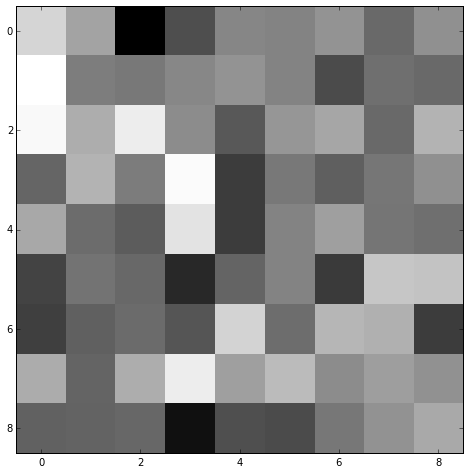

In [39]:
plt.imshow(np.sum(W0_strongest, axis=0))

In [41]:
space, time = ft.decompose(W0_strongest)

In [42]:
space.shape

(9, 9)

In [43]:
time.shape

(40,)

(<matplotlib.figure.Figure at 0x1199106d0>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x119910990>,
  <matplotlib.axes._subplots.AxesSubplot at 0x119910cd0>))

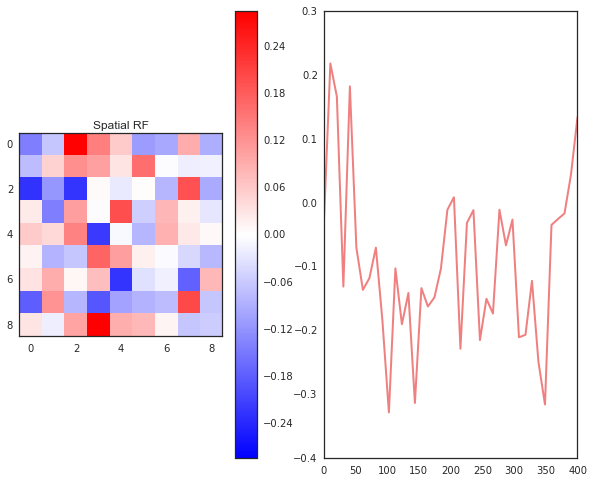

In [49]:
viz.plotsta(np.linspace(0,400,40), W0_strongest)

# What does the actual receptive field look like? (Natural Scenes)

In [50]:
data_dir = '/Users/lmcintosh/Documents/Stanford/00 Baccus Lab/Data 2015_10_07/naturalscene.h5'

In [53]:
def rolling_window(array, window):
	"""
	Make an ndarray with a rolling window of the last dimension
	Parameters
	----------
	array : array_like
		Array to add rolling window to
	window : int
		Size of rolling window
	Returns
	-------
	Array that is a view of the original array with a added dimension
	of size w.
	Examples
	--------
	>>> x=np.arange(10).reshape((2,5))
	>>> rolling_window(x, 3)
	array([[[0, 1, 2], [1, 2, 3], [2, 3, 4]],
		   [[5, 6, 7], [6, 7, 8], [7, 8, 9]]])
	Calculate rolling mean of last dimension:
	>>> np.mean(rolling_window(x, 3), -1)
	array([[ 1.,  2.,  3.],
		   [ 6.,  7.,  8.]])
	"""
	assert window >= 1, "`window` must be at least 1."
	assert window < array.shape[-1], "`window` is too long."

	# # with strides
	shape = array.shape[:-1] + (array.shape[-1] - window, window)
	strides = array.strides + (array.strides[-1],)
	return np.lib.stride_tricks.as_strided(array, shape=shape, strides=strides)

In [54]:
def loadData(data_dir):
	scenes = h5py.File(data_dir, 'r')
	stim = np.array(scenes['train/stimulus'])
	stim = stim.T
	X = rolling_window(stim, 40)
	X = np.rollaxis(X, 2)
	X = np.rollaxis(X, 3, 1)
	#Truncate rates to appropriate time frame
	y = np.array(scenes['train/response/firing_rate_10ms'])
	for i in xrange(y.shape[0]): #normalize firing rate of each cell to be between 0 and 1
		if np.max(y[i]) != 0:
			y[i] /= np.max(y[i])
	y = y.T
	y = y[40:,:]
	stim_2 = np.array(scenes['test/stimulus'])
	stim_2 = stim_2.T
	X_2 = rolling_window(stim_2, 40)
	X_2 = np.rollaxis(X_2, 2)
	X_2 = np.rollaxis(X_2, 3, 1)
	#Truncate rates to appropriate time frame
	y_2 = np.array(scenes['test/response/firing_rate_10ms'])
	for i in xrange(y_2.shape[0]): #normalize firing rate of each cell to be between 0 and 1
		if np.max(y_2[i]) != 0:
			y_2[i] /= np.max(y_2[i])
	y_2 = y_2.T
	y_2 = y_2[40:,:]
	print X.shape
	print y.shape
	print X_2.shape
	print y_2.shape
	return X, y, X_2, y_2

In [55]:
X_train, y_train, X_test, y_test = loadData(data_dir)

(359762, 40, 50, 50)
(359762, 9)
(5957, 40, 50, 50)
(5957, 9)


In [56]:
sta = np.zeros_like(X_train[0], dtype='float32')
for idx, label in enumerate(y_train[:,0]):
    sta += label * X_train[idx].astype('float32')

(<matplotlib.figure.Figure at 0x1242697d0>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x116680510>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1242a9110>))

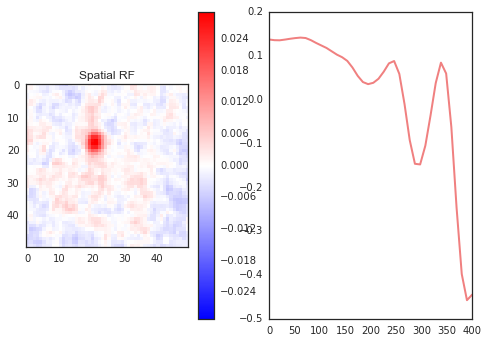

In [57]:
viz.plotsta(np.linspace(0,400,40), sta)

# Full resolution spatial STA and the true 9x9 receptive field center

<matplotlib.colorbar.Colorbar instance at 0x1607c4488>

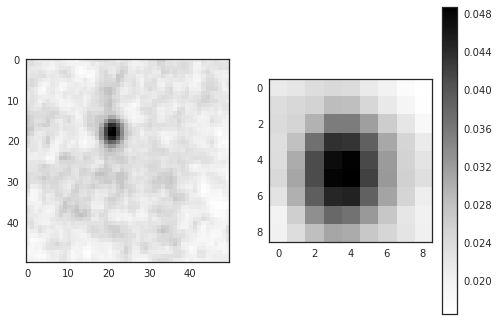

In [91]:
spatial_sta, temporal_sta = ft.decompose(sta)
plt.subplot(1,2,1)
plt.imshow(spatial_sta)
plt.subplot(1,2,2)
plt.imshow(spatial_sta[13:22,17:26])
plt.colorbar()

# Plot all 16 filters in layer_0

In [76]:
(np.min(W0), np.max(W0))

(-0.25516471, 0.226861)

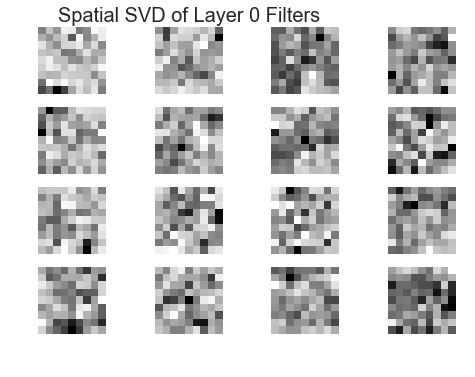

In [78]:
num_cols = 4
num_rows = 4
idxs = range(num_cols)
for y in range(num_cols):
    for i in range(num_rows):
        plt_idx = i * num_cols + y + 1
        space,time = ft.decompose(W0[plt_idx-1])
        plt.subplot(num_rows, num_cols, plt_idx)
        plt.imshow(space) #, clim=[np.min(W0), np.max(W0)])
        plt.grid('off')
        plt.axis('off')
        if i == num_rows-1:
            plt.xlabel('Time (samples)', fontsize=14)
        if y == 0:
            plt.ylabel('Space (samples)', fontsize=14)
        if i == 0:
            if y == 1:
                plt.title('Spatial SVD of Layer 0 Filters', fontsize=20)

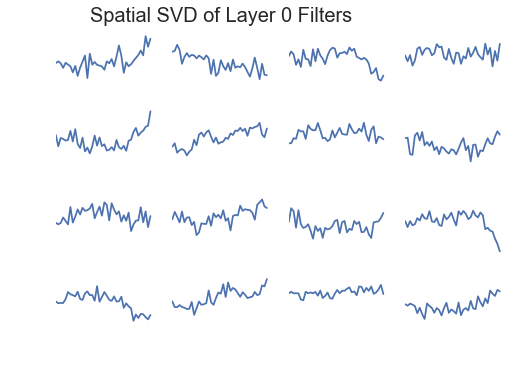

In [74]:
num_cols = 4
num_rows = 4
idxs = range(num_cols)
for y in range(num_cols):
    for i in range(num_rows):
        plt_idx = i * num_cols + y + 1
        space,time = ft.decompose(W0[plt_idx-1])
        if plt_idx == 1:
            ax1 = plt.subplot(num_rows, num_cols, plt_idx)
        else:
            plt.subplot(num_rows, num_cols, plt_idx, sharey=ax1)
        plt.plot(time)
        plt.grid('off')
        plt.axis('off')
        if i == num_rows-1:
            plt.xlabel('Time (samples)', fontsize=14)
        if y == 0:
            plt.ylabel('Space (samples)', fontsize=14)
        if i == 0:
            if y == 1:
                plt.title('Spatial SVD of Layer 0 Filters', fontsize=20)

# Plot all 32 filters in layer 4

In [65]:
W4 = weights['layer_4']['param_0']
W4.shape

(13456, 32)

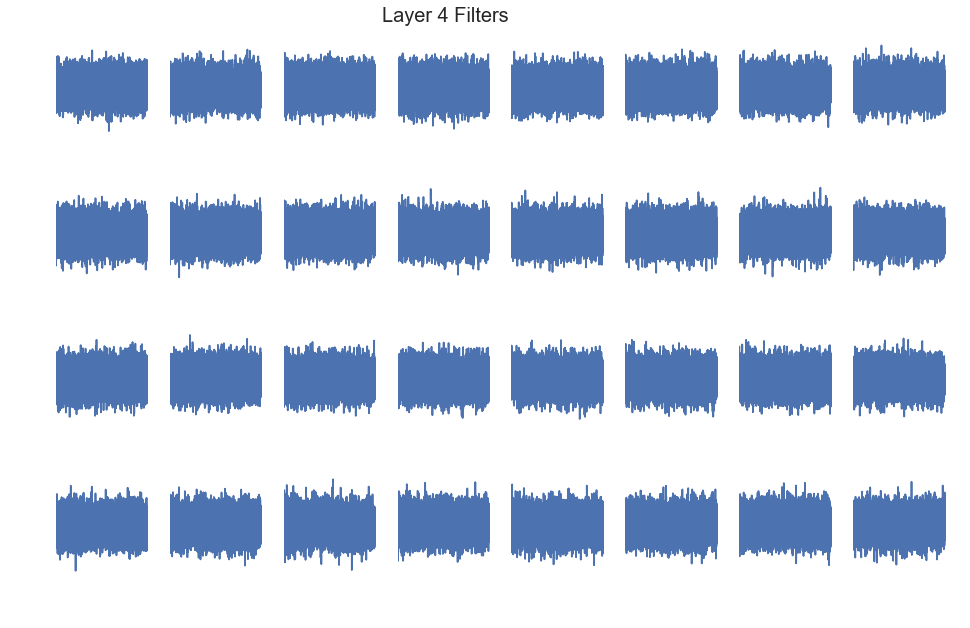

In [73]:
fig = plt.gcf()
fig.set_size_inches((16,10))
num_cols = 8
num_rows = 4
idxs = range(num_cols)
for y in range(num_cols):
    for i in range(num_rows):
        plt_idx = i * num_cols + y + 1
        if plt_idx == 1:
            ax1 = plt.subplot(num_rows, num_cols, plt_idx)
        else:
            plt.subplot(num_rows, num_cols, plt_idx, sharey=ax1)
        plt.plot(W4[:,plt_idx-1])
        plt.grid('off')
        plt.axis('off')
        if i == num_rows-1:
            plt.xlabel('Time (samples)', fontsize=14)
        if y == 0:
            plt.ylabel('Space (samples)', fontsize=14)
        if i == 0:
            if y == 3:
                plt.title('Layer 4 Filters', fontsize=20)

# Weight all filters by their bias

In [93]:
b0 = weights['layer_0']['param_1']

In [94]:
avg_W0 = np.zeros_like(W0_strongest)
for idf, filt in enumerate(W0):
    avg_W0 += b0[idf] * filt
avg_W0 /= len(b0)

(<matplotlib.figure.Figure at 0x15f393bd0>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x15e21d810>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1607cd610>))

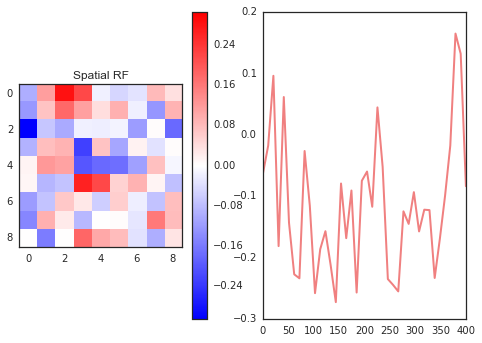

In [95]:
viz.plotsta(np.linspace(0,400,40), avg_W0)

# Checking out Niru's convnet model 2015-11-05 17.11.31

In [7]:
import h5py

In [8]:
from os.path import expanduser
from keras.models import model_from_json
import json

In [9]:
data_dir = expanduser('~/Dropbox/deep-retina/saved_models/2015-11-06 10.39.30 convnet/')
architecture_filename = 'architecture.json'
weight_filename = 'epoch12_iter0785_weights.h5'

In [10]:
architecture_data = open(data_dir + architecture_filename, 'r')
architecture_string = architecture_data.read()
model = model_from_json(architecture_string)
model.load_weights(data_dir + weight_filename)

In [7]:
architecture_string

'{"class_mode": "categorical", "layers": [{"b_constraint": null, "input_shape": [40, 50, 50], "subsample": [1, 1], "nb_row": 16, "name": "Convolution2D", "init": "normal", "activity_regularizer": null, "W_regularizer": {"name": "WeightRegularizer", "l2": 0.0, "l1": 0.0}, "b_regularizer": null, "nb_col": 16, "nb_filter": 4, "border_mode": "same", "activation": "relu", "W_constraint": null}, {"name": "MaxPooling2D", "ignore_border": true, "stride": [2, 2], "pool_size": [2, 2]}, {"name": "Flatten"}, {"input_dim": null, "b_constraint": null, "output_dim": 32, "name": "Dense", "init": "normal", "activity_regularizer": null, "W_regularizer": {"name": "WeightRegularizer", "l2": 0.0, "l1": 0.0}, "b_regularizer": null, "W_constraint": null, "activation": "relu"}, {"input_dim": null, "b_constraint": null, "output_dim": 1, "name": "Dense", "init": "normal", "activity_regularizer": null, "W_regularizer": {"name": "WeightRegularizer", "l2": 0.0, "l1": 0.0}, "b_regularizer": null, "W_constraint": nu

In [11]:
weights = h5py.File(data_dir + weight_filename, 'r')
list(weights)

[u'layer_0', u'layer_1', u'layer_2', u'layer_3', u'layer_4']

In [12]:
W0 = weights['layer_0']['param_0']

In [9]:
W0.shape

(4, 40, 16, 16)

In [11]:
%matplotlib inline

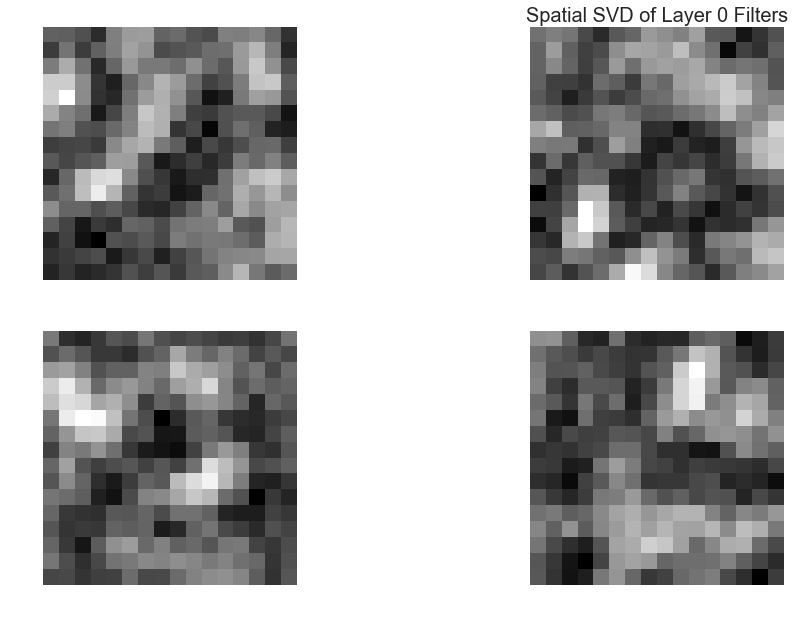

In [12]:
fig = plt.gcf()
fig.set_size_inches((16,10))
num_cols = 2
num_rows = 2
idxs = range(num_cols)
for y in range(num_cols):
    for i in range(num_rows):
        plt_idx = i * num_cols + y + 1
        space,time = ft.decompose(W0[plt_idx-1])
        plt.subplot(num_rows, num_cols, plt_idx)
        plt.imshow(space) #, clim=[np.min(W0), np.max(W0)])
        plt.grid('off')
        plt.axis('off')
        if i == num_rows-1:
            plt.xlabel('Time (samples)', fontsize=14)
        if y == 0:
            plt.ylabel('Space (samples)', fontsize=14)
        if i == 0:
            if y == 1:
                plt.title('Spatial SVD of Layer 0 Filters', fontsize=20)

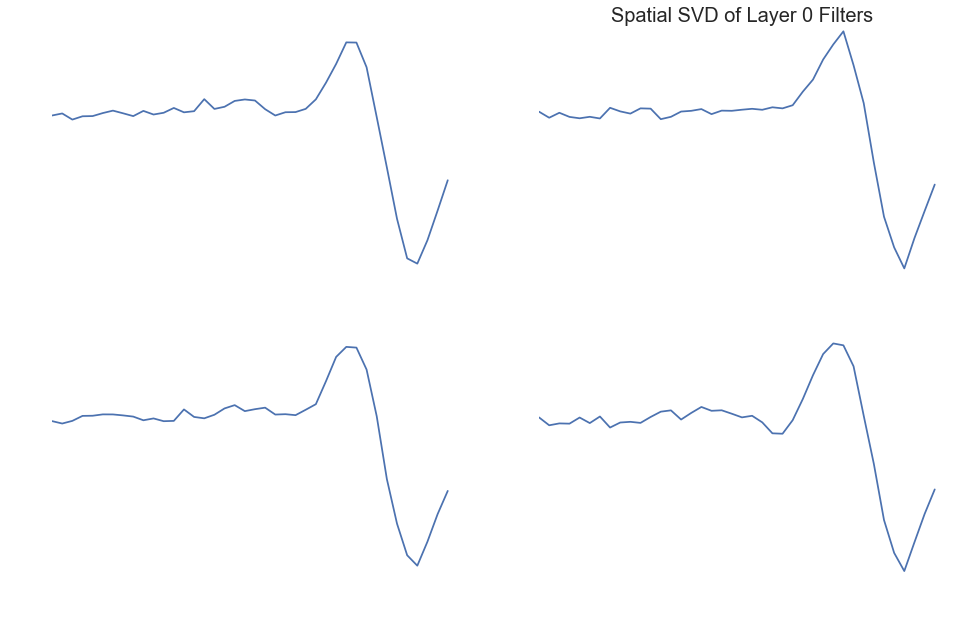

In [14]:
fig = plt.gcf()
fig.set_size_inches((16,10))
num_cols = 2
num_rows = 2
idxs = range(num_cols)
for y in range(num_cols):
    for i in range(num_rows):
        plt_idx = i * num_cols + y + 1
        space,time = ft.decompose(W0[plt_idx-1])
        if plt_idx == 1:
            ax1 = plt.subplot(num_rows, num_cols, plt_idx)
        else:
            plt.subplot(num_rows, num_cols, plt_idx, sharey=ax1)
        plt.plot(time)
        plt.grid('off')
        plt.axis('off')
        if i == num_rows-1:
            plt.xlabel('Time (samples)', fontsize=14)
        if y == 0:
            plt.ylabel('Space (samples)', fontsize=14)
        if i == 0:
            if y == 1:
                plt.title('Spatial SVD of Layer 0 Filters', fontsize=20)

In [15]:
W3 = weights['layer_3']['param_0']
W3.shape

(2500, 32)

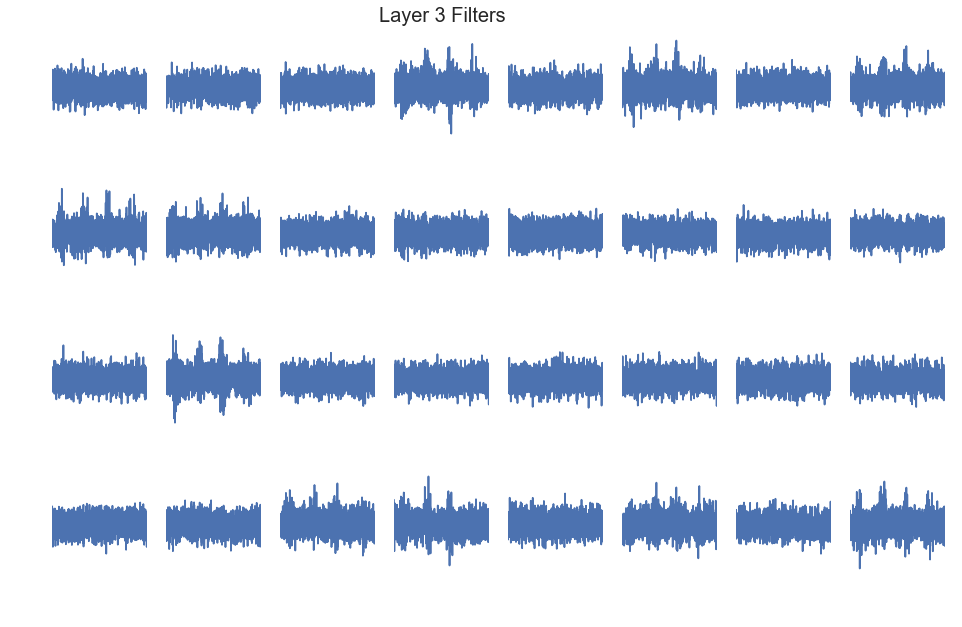

In [16]:
fig = plt.gcf()
fig.set_size_inches((16,10))
num_cols = 8
num_rows = 4
idxs = range(num_cols)
for y in range(num_cols):
    for i in range(num_rows):
        plt_idx = i * num_cols + y + 1
        if plt_idx == 1:
            ax1 = plt.subplot(num_rows, num_cols, plt_idx)
        else:
            plt.subplot(num_rows, num_cols, plt_idx, sharey=ax1)
        plt.plot(W3[:,plt_idx-1])
        plt.grid('off')
        plt.axis('off')
        if i == num_rows-1:
            plt.xlabel('Time (samples)', fontsize=14)
        if y == 0:
            plt.ylabel('Space (samples)', fontsize=14)
        if i == 0:
            if y == 3:
                plt.title('Layer 3 Filters', fontsize=20)

In [17]:
W4 = weights['layer_4']['param_0']
W4.shape

(32, 1)

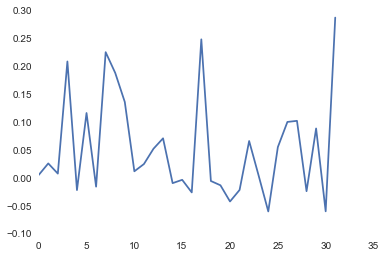

In [18]:
plt.plot(W4)

In [19]:
architecture_data = open(data_dir + architecture_filename, 'r')
architecture_dict = json.load(architecture_data)

In [20]:
architecture_dict

{u'class_mode': u'categorical',
 u'layers': [{u'W_constraint': None,
   u'W_regularizer': {u'l1': 0.0, u'l2': 0.0, u'name': u'WeightRegularizer'},
   u'activation': u'relu',
   u'activity_regularizer': None,
   u'b_constraint': None,
   u'b_regularizer': None,
   u'border_mode': u'same',
   u'init': u'normal',
   u'input_shape': [40, 50, 50],
   u'name': u'Convolution2D',
   u'nb_col': 16,
   u'nb_filter': 4,
   u'nb_row': 16,
   u'subsample': [1, 1]},
  {u'ignore_border': True,
   u'name': u'MaxPooling2D',
   u'pool_size': [2, 2],
   u'stride': [2, 2]},
  {u'name': u'Flatten'},
  {u'W_constraint': None,
   u'W_regularizer': {u'l1': 0.0, u'l2': 0.0, u'name': u'WeightRegularizer'},
   u'activation': u'relu',
   u'activity_regularizer': None,
   u'b_constraint': None,
   u'b_regularizer': None,
   u'init': u'normal',
   u'input_dim': None,
   u'name': u'Dense',
   u'output_dim': 32},
  {u'W_constraint': None,
   u'W_regularizer': {u'l1': 0.0, u'l2': 0.0, u'name': u'WeightRegularizer'},
 

In [21]:
def rolling_window(array, window):
	"""
	Make an ndarray with a rolling window of the last dimension
	Parameters
	----------
	array : array_like
		Array to add rolling window to
	window : int
		Size of rolling window
	Returns
	-------
	Array that is a view of the original array with a added dimension
	of size w.
	Examples
	--------
	>>> x=np.arange(10).reshape((2,5))
	>>> rolling_window(x, 3)
	array([[[0, 1, 2], [1, 2, 3], [2, 3, 4]],
		   [[5, 6, 7], [6, 7, 8], [7, 8, 9]]])
	Calculate rolling mean of last dimension:
	>>> np.mean(rolling_window(x, 3), -1)
	array([[ 1.,  2.,  3.],
		   [ 6.,  7.,  8.]])
	"""
	assert window >= 1, "`window` must be at least 1."
	assert window < array.shape[-1], "`window` is too long."

	# # with strides
	shape = array.shape[:-1] + (array.shape[-1] - window, window)
	strides = array.strides + (array.strides[-1],)
	return np.lib.stride_tricks.as_strided(array, shape=shape, strides=strides)

In [22]:
def loadData(data_dir):
	scenes = h5py.File(data_dir, 'r')
	stim = np.array(scenes['train/stimulus'])
	stim = stim.T
	X = rolling_window(stim, 40)
	X = np.rollaxis(X, 2)
	X = np.rollaxis(X, 3, 1)
	#Truncate rates to appropriate time frame
	y = np.array(scenes['train/response/firing_rate_10ms'])
	for i in xrange(y.shape[0]): #normalize firing rate of each cell to be between 0 and 1
		if np.max(y[i]) != 0:
			y[i] /= np.max(y[i])
	y = y.T
	y = y[40:,:]
	stim_2 = np.array(scenes['test/stimulus'])
	stim_2 = stim_2.T
	X_2 = rolling_window(stim_2, 40)
	X_2 = np.rollaxis(X_2, 2)
	X_2 = np.rollaxis(X_2, 3, 1)
	#Truncate rates to appropriate time frame
	y_2 = np.array(scenes['test/response/firing_rate_10ms'])
	for i in xrange(y_2.shape[0]): #normalize firing rate of each cell to be between 0 and 1
		if np.max(y_2[i]) != 0:
			y_2[i] /= np.max(y_2[i])
	y_2 = y_2.T
	y_2 = y_2[40:,:]
	print X.shape
	print y.shape
	print X_2.shape
	print y_2.shape
	return X, y, X_2, y_2

In [23]:
data_dir = '/Users/lmcintosh/Documents/Stanford/00 Baccus Lab/Data 2015_10_07/whitenoise.h5'
X_train, y_train, X_test, y_test = loadData(data_dir)

(359762, 40, 50, 50)
(359762, 9)
(5957, 40, 50, 50)
(5957, 9)


In [40]:
from scipy.stats import zscore
y_pred_test = model.predict(zscore(X_test.astype('float32')))

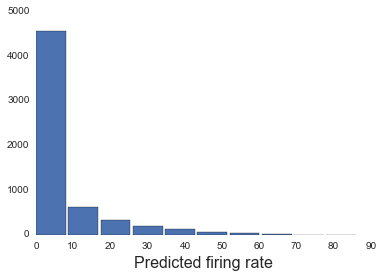

In [44]:
count, bin_edges = np.histogram(y_pred_test)
plt.bar(bin_edges[:-1], count, width=8)
plt.xlabel('Predicted firing rate', fontsize=16)

In [45]:
from scipy.stats import pearsonr

In [48]:
y_test.shape

(5957, 9)

In [49]:
y_pred_test.shape

(5957, 1)

In [50]:
pearsonr(y_test[:,0], y_pred_test[:,0])

(0.61695007386334111, 0.0)

In [23]:
ln_fit = np.zeros_like(X_train[0], dtype='float32')
for idx, sample in enumerate(X_train):
    ln_fit += y_pred[idx] * sample
ln_fit /= len(y_pred)

In [19]:
%matplotlib inline

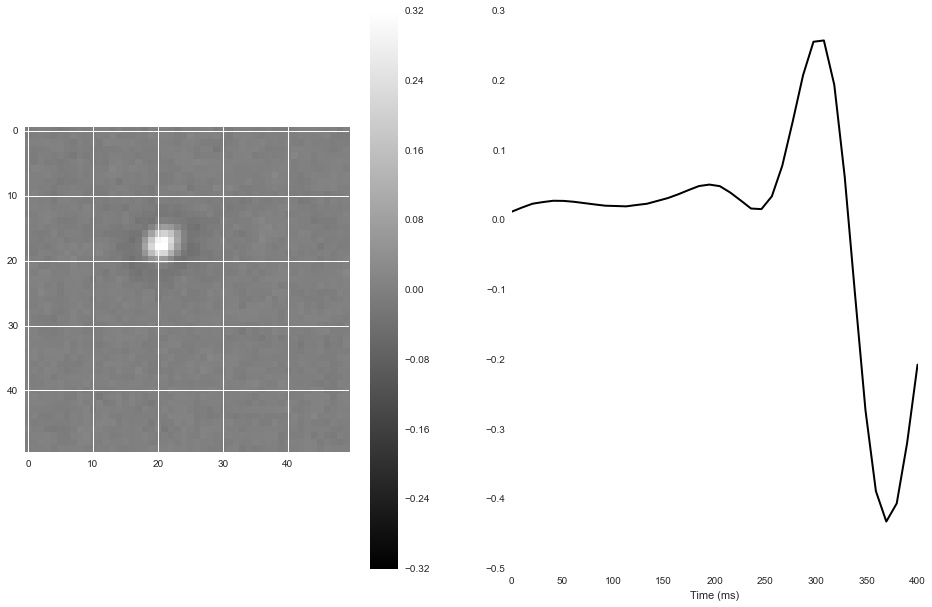

In [26]:
fig = plt.gcf()
fig.set_size_inches((16,10))

space, time = ft.decompose(ln_fit)
plt.subplot(1,2,1)
plt.imshow(space, clim=[-0.32, 0.32])
plt.colorbar()

plt.subplot(1,2,2)
plt.plot(np.linspace(0,400,40), time, 'k', linewidth=2)
plt.xlabel('Time (ms)')

In [22]:
ln_fit.dtype

dtype('uint8')

In [27]:
true_sta = np.zeros_like(X_train[0], dtype='float32')
for idx, sample in enumerate(X_train):
    true_sta += y_train[idx,0] * sample
true_sta /= len(y_train[:,0])

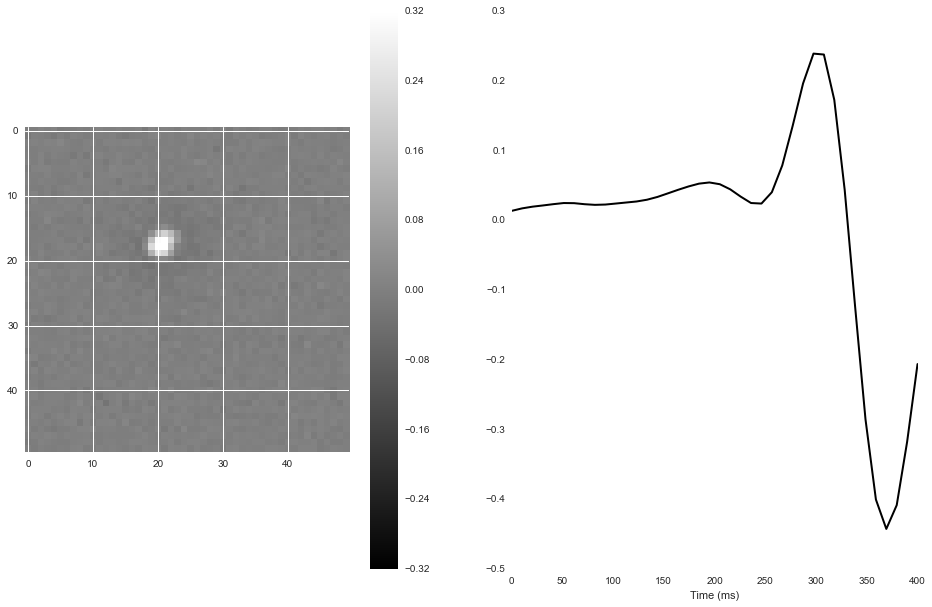

In [28]:
fig = plt.gcf()
fig.set_size_inches((16,10))

space, time = ft.decompose(true_sta)
plt.subplot(1,2,1)
plt.imshow(space, clim=[-0.32, 0.32])
plt.colorbar()

plt.subplot(1,2,2)
plt.plot(np.linspace(0,400,40), time, 'k', linewidth=2)
plt.xlabel('Time (ms)')

In [29]:
space_fit_sta, time_fit_sta = ft.decompose(ln_fit)
space_true_sta, time_true_sta = ft.decompose(true_sta)

<matplotlib.colorbar.Colorbar instance at 0x12cb77ef0>

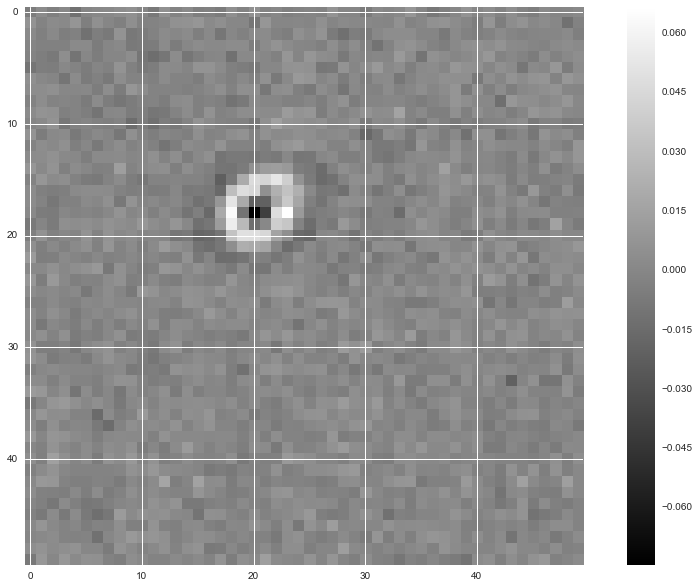

In [32]:
fig = plt.gcf()
fig.set_size_inches((16,10))
plt.imshow(space_fit_sta - space_true_sta)
plt.colorbar()

In [33]:
(np.min(space_fit_sta), np.max(space_fit_sta))

(-0.036529824, 0.33758649)

In [34]:
(np.min(space_true_sta), np.max(space_true_sta))

(-0.036497448, 0.41207787)

In [52]:
np.mean(y_test[:,0])

0.055105918783581898

# Niru's 11-06 20.08.37 convnet with ~0.45 corr coeff on held out natural scenes

In [3]:
data_dir = expanduser('~/Dropbox/deep-retina/saved/lenna.nirum/2015-11-06 20.08.37 convnet/')
weights_filename = 'epoch009_iter00700_weights.h5'
architecture_filename = 'architecture.json'

In [4]:
architecture_data = open(data_dir + architecture_filename, 'r')
architecture_string = architecture_data.read()
model = model_from_json(architecture_string)
model.load_weights(data_dir + weights_filename)

In [5]:
weights = h5py.File(data_dir + weights_filename, 'r')
list(weights)

[u'layer_0', u'layer_1', u'layer_2', u'layer_3', u'layer_4']

In [6]:
W0 = weights['layer_0']['param_0']
W0.shape

(4, 40, 13, 13)

In [8]:
%matplotlib inline

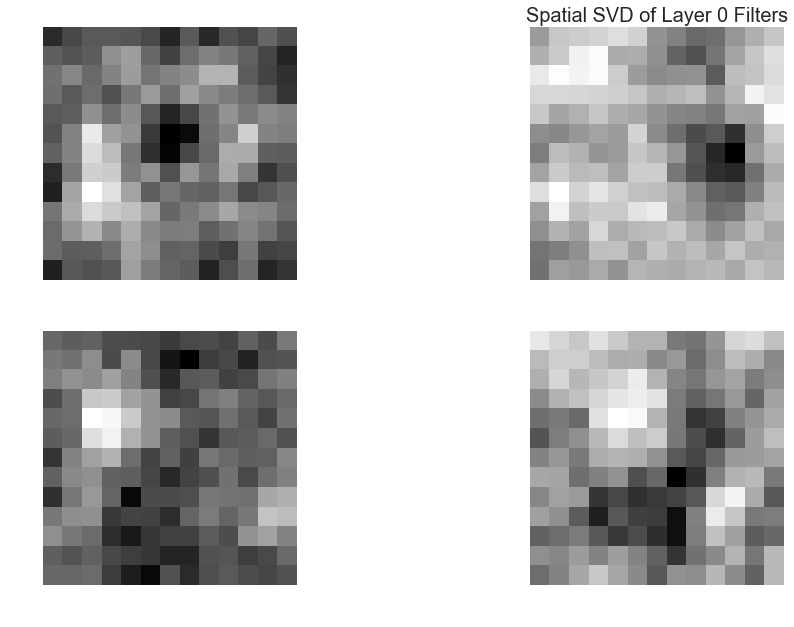

In [9]:
fig = plt.gcf()
fig.set_size_inches((16,10))
num_cols = 2
num_rows = 2
idxs = range(num_cols)
for y in range(num_cols):
    for i in range(num_rows):
        plt_idx = i * num_cols + y + 1
        space,time = ft.decompose(W0[plt_idx-1])
        plt.subplot(num_rows, num_cols, plt_idx)
        plt.imshow(space) #, clim=[np.min(W0), np.max(W0)])
        plt.grid('off')
        plt.axis('off')
        if i == num_rows-1:
            plt.xlabel('Time (samples)', fontsize=14)
        if y == 0:
            plt.ylabel('Space (samples)', fontsize=14)
        if i == 0:
            if y == 1:
                plt.title('Spatial SVD of Layer 0 Filters', fontsize=20)

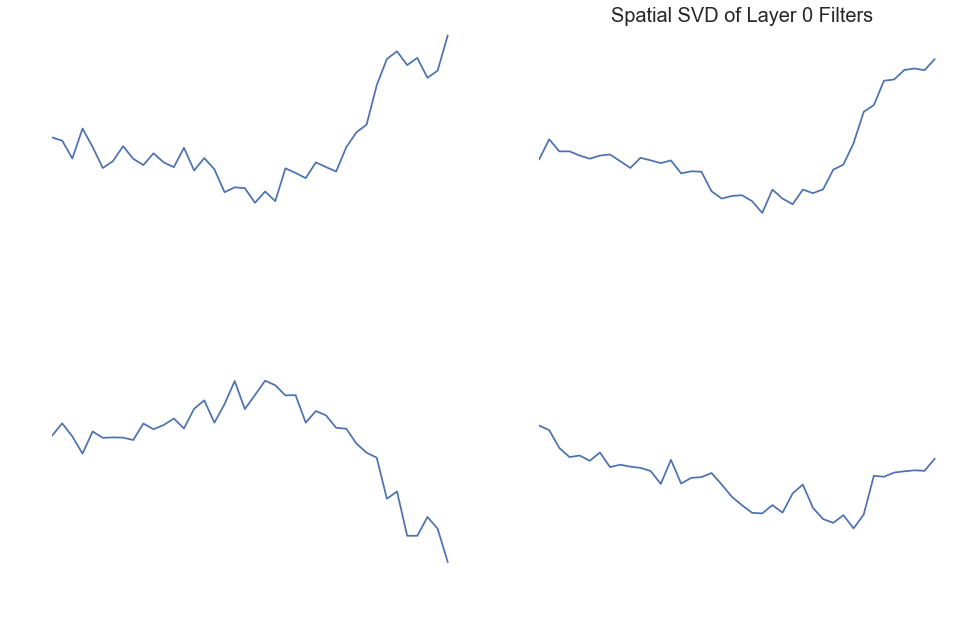

In [10]:
fig = plt.gcf()
fig.set_size_inches((16,10))
num_cols = 2
num_rows = 2
idxs = range(num_cols)
for y in range(num_cols):
    for i in range(num_rows):
        plt_idx = i * num_cols + y + 1
        space,time = ft.decompose(W0[plt_idx-1])
        if plt_idx == 1:
            ax1 = plt.subplot(num_rows, num_cols, plt_idx)
        else:
            plt.subplot(num_rows, num_cols, plt_idx, sharey=ax1)
        plt.plot(time)
        plt.grid('off')
        plt.axis('off')
        if i == num_rows-1:
            plt.xlabel('Time (samples)', fontsize=14)
        if y == 0:
            plt.ylabel('Space (samples)', fontsize=14)
        if i == 0:
            if y == 1:
                plt.title('Spatial SVD of Layer 0 Filters', fontsize=20)

In [11]:
W3 = weights['layer_3']['param_0']
W3.shape

(2500, 16)

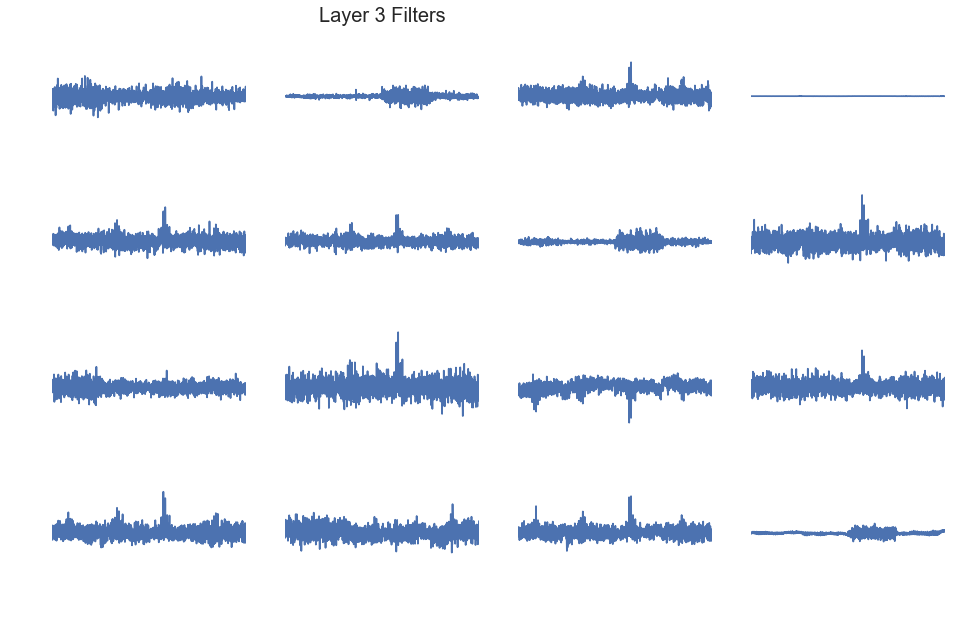

In [14]:
fig = plt.gcf()
fig.set_size_inches((16,10))
num_cols = 4
num_rows = 4
idxs = range(num_cols)
for y in range(num_cols):
    for i in range(num_rows):
        plt_idx = i * num_cols + y + 1
        if plt_idx == 1:
            ax1 = plt.subplot(num_rows, num_cols, plt_idx)
        else:
            plt.subplot(num_rows, num_cols, plt_idx, sharey=ax1)
        plt.plot(W3[:,plt_idx-1])
        plt.grid('off')
        plt.axis('off')
        if i == num_rows-1:
            plt.xlabel('Time (samples)', fontsize=14)
        if y == 0:
            plt.ylabel('Space (samples)', fontsize=14)
        if i == 0:
            if y == 1:
                plt.title('Layer 3 Filters', fontsize=20)

In [15]:
W3.shape

(2500, 16)

In [16]:
2500/(25*25)

4

In [37]:
blah = W3[:,1]

<matplotlib.colorbar.Colorbar instance at 0x1361b3440>

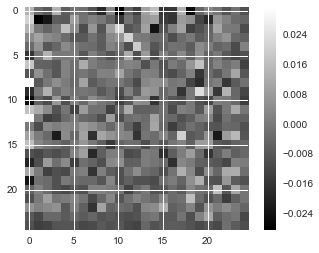

In [46]:
brah = blah.reshape((25,25,4))
bloop = blah.reshape((4,25,25))
#plt.imshow(brah[:,:,3])
plt.imshow(bloop[3])
plt.colorbar()

In [112]:
W3.shape

(2500, 16)

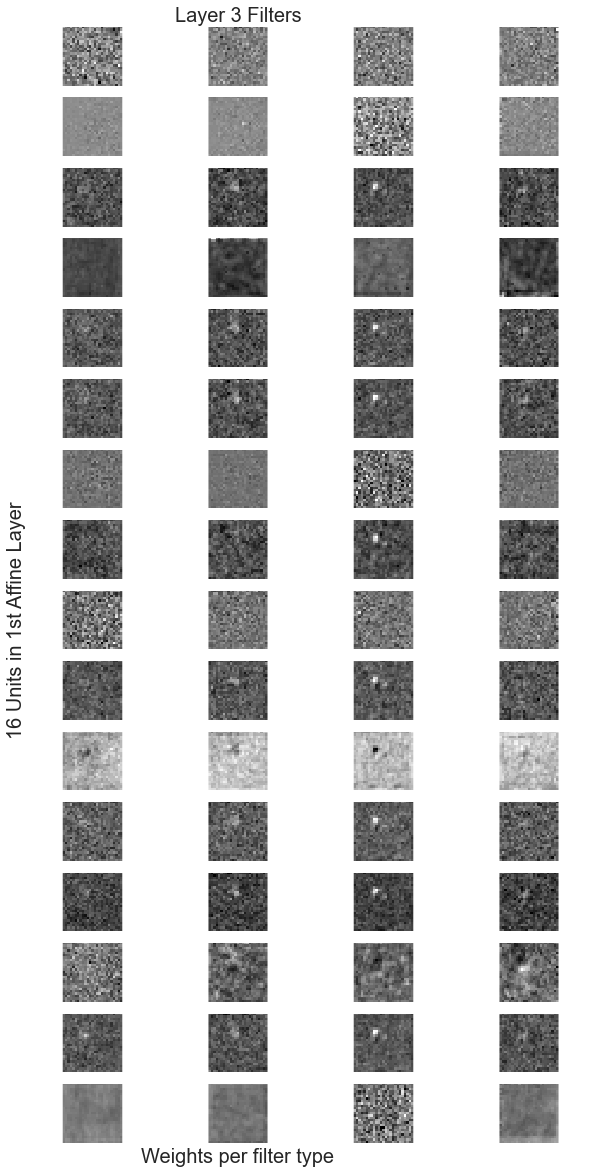

In [65]:
fig = plt.gcf()
fig.set_size_inches((10,20))
num_cols = 4
num_rows = W3.shape[1]
idxs = range(num_cols)
for i in range(num_rows):
    these_filters = W3[:,i].reshape((4,25,25))
    colorlimit = [np.min(these_filters), np.max(these_filters)]
    for y in range(num_cols):
        plt_idx = i * num_cols + y + 1
        if plt_idx == 1:
            ax1 = plt.subplot(num_rows, num_cols, plt_idx)
        else:
            plt.subplot(num_rows, num_cols, plt_idx, sharey=ax1)
        ax = plt.imshow(these_filters[y], clim=colorlimit)
        plt.xticks([]) 
        plt.yticks([]) 
        plt.grid('off')
        #plt.axis('off')
        if i == num_rows-1:
            if y == 1:
                plt.xlabel('Weights per filter type', fontsize=20)
        if y == 0:
            if i == 8:
                plt.ylabel('16 Units in 1st Affine Layer', fontsize=20)
        if i == 0:
            if y == 1:
                plt.title('Layer 3 Filters', fontsize=20)
        #plt.tight_layout()
plt.savefig('weights_layer3_images.png', dpi=500)

# Experiment with spatiotemporal visualizations

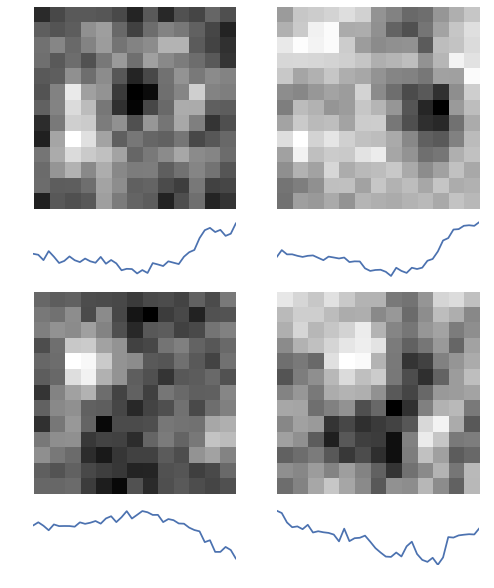

In [100]:
fig = plt.gcf()
fig.set_size_inches((8,10))
num_cols = 2
num_rows = 2
idxs = range(num_cols)
for y in range(num_cols):
    for i in range(num_rows):
        plt_idx = i * num_cols + y + 1
        space,time = ft.decompose(W0[plt_idx-1])
        #plt.subplot(num_rows, num_cols, plt_idx)
        ax = plt.subplot2grid((num_rows*4, num_cols), (4*i, y), rowspan=3)
        ax.imshow(space) #, clim=[np.min(W0), np.max(W0)])
        plt.grid('off')
        plt.axis('off')
        
        ax = plt.subplot2grid((num_rows*4, num_cols), (4*i+3, y), rowspan=1)
        ax.plot(np.linspace(0,400,40), time)
        
        plt.grid('off')
        plt.axis('off')
#         if i == num_rows-1:
#             plt.xlabel('Time (samples)', fontsize=14)
#         if y == 0:
#             plt.ylabel('Space (samples)', fontsize=14)
#         if i == 0:
#             if y == 1:
#                 plt.title('Spatial SVD of Layer 0 Filters', fontsize=20)

In [103]:
W0.shape

(4, 40, 13, 13)

In [106]:
cd ..

/Users/lmcintosh/Git/deep-retina


In [108]:
ls

README.md               main.py                 models.pyc              optimization_snapshots/ preprocessing.pyc       utils.py                visualizations.py
callbacks.pyc           models.py               notebooks/              preprocessing.py        requirements.txt        utils.pyc


In [1]:
from deepretina.visualizations import visualize_convnet_weights

Using gpu device 0: GeForce GT 750M (CNMeM is disabled)


In [2]:
import theano

In [3]:
from pyret.filtertools import lowranksta

In [115]:
W0.shape

(4, 40, 13, 13)

In [143]:
fk, u, s, v = lowranksta(W0[0], k=3)

In [144]:
fk.shape

(40, 13, 13)

In [145]:
u.shape

(40, 40)

(-1, 40)

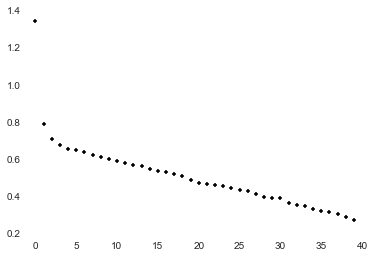

In [146]:
plt.plot(s, 'k.')
plt.xlim([-1,40])

In [134]:
v.shape

(40, 169)

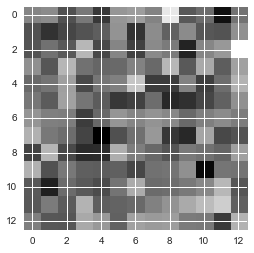

In [150]:
plt.imshow(v[1,:].reshape((13,13)))

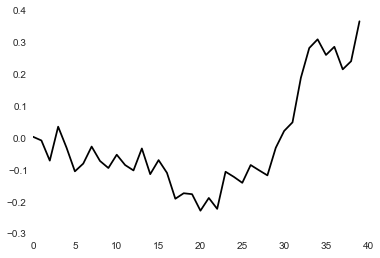

In [153]:
plt.plot(u[:,0], 'k')

In [4]:
from deepretina.preprocessing import datagen, loadexpt

In [163]:
training = loadexpt(0, 'naturalscene', 'train', 40, fraction=1.)

Loading training data... Done.


In [89]:
boom = weights['layer_4']['param_0']

In [90]:
boom.shape

(32, 1)

In [164]:
get_3rd_layer_output = theano.function([model.layers[0].input], 
                                       model.layers[3].get_output(train=False))
get_4th_layer_output = theano.function([model.layers[0].input], 
                                       model.layers[4].get_output(train=False))

In [165]:
y_pred = []
y_true = []
L3_activations = []
L4_activations = []
i = 0
for X, y in datagen(50, *training):
    y_pred.extend(model.predict(X))
    y_true.extend(y)
    L3_activations.extend(get_3rd_layer_output(X))
    L4_activations.extend(get_4th_layer_output(X))
    #i += 1
    #if i > 20:
    #    break
    

In [166]:
len(L4_activations)

359750

In [167]:
L3 = np.array(L3_activations)
L4 = np.array(L4_activations)

In [168]:
L3.shape

(359750, 32)

In [169]:
L4.shape

(359750, 1)

In [94]:
len(L3_activations)

35900

In [70]:
len(y_pred)

35900

In [71]:
len(y_true)

35900

In [72]:
y_pred[0]

array([ 6.68852806])

In [73]:
import numpy as np

In [74]:
blah = np.array(y_pred)

In [75]:
blah.shape

(35900, 1)

In [76]:
bloop = np.array(y_true)

In [77]:
from scipy.stats import pearsonr

In [78]:
pearsonr(blah[:,0], bloop)

(0.40639851957114731, 0.0)

In [21]:
list(weights)

[u'layer_0', u'layer_1', u'layer_2', u'layer_3', u'layer_4']

In [22]:
W0 = weights['layer_0']['param_0']

In [23]:
W0.shape

(4, 40, 16, 16)

In [24]:
import theano

In [79]:
get_3rd_layer_output = theano.function([model.layers[0].input], 
                                       model.layers[3].get_output(train=False))
layer_output = get_3rd_layer_output(X)

In [80]:
layer_output.shape

(50, 32)

In [81]:
import matplotlib.pyplot as plt
%matplotlib inline

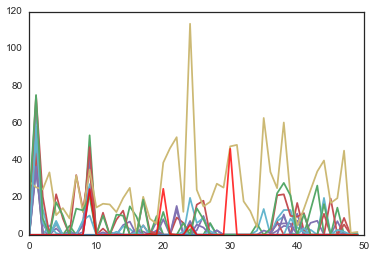

In [82]:
blurt = plt.plot(layer_output)
plt.plot(y_true[-50:], 'r', alpha=0.8)

In [29]:
from scipy.signal import convolve, correlate, fftconvolve

In [58]:
X.shape

(50, 40, 50, 50)

In [64]:
layer_output.shape

(50, 32)

In [58]:
stas = np.empty((32, 40, 50, 50), dtype='float')
for idx, sample in enumerate(X):
    for unit in range(32):
        stas[unit] += layer_output[idx, unit] * sample
    

In [99]:
L3.shape

(35900, 32)

In [125]:
tmp = []
for idx, (X, y) in enumerate(datagen(1, *training)):
    tmp.append(idx)
    

In [126]:
tmp[-1]

35939

In [103]:
L3_stas = np.empty((32, 40, 50, 50), dtype='float')
L4_sta = np.empty((40, 50, 50), dtype='float')
for X, y in enumerate(datagen(50, *training)):
    L4_sta += L4[idx] * X[0]
    for unit in range(32):
        L3_stas[unit] += L3[idx, unit] * X[0]

IndexError: index 35900 is out of bounds for axis 0 with size 35900

In [170]:
L3_stas = np.empty((32, 40, 50, 50), dtype='float')
L4_sta = np.empty((40, 50, 50), dtype='float')
for X, y in datagen(50, *training):
    for idx, sample in enumerate(X):
        L4_sta += L4[idx*50] * sample
        for unit in range(32):
            L3_stas[unit] += L3[idx*50, unit] * sample

In [39]:
import pyret.filtertools as ft
import pyret.visualizations as viz

In [143]:
from deepretina.visualizations import singular_values

In [53]:
%matplotlib inline

(-1, 40)

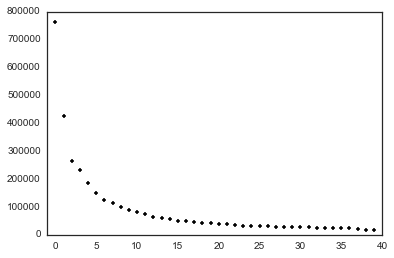

In [178]:
which_sta = -1
space, time = ft.decompose(L3_stas[which_sta])
plt.plot(singular_values(L3_stas[which_sta]), 'k.')
plt.xlim([-1, 40])

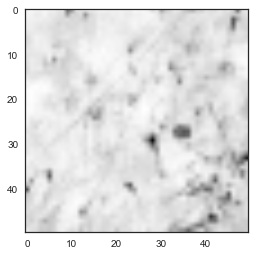

In [161]:
plt.imshow(L3_stas[which_sta][30])

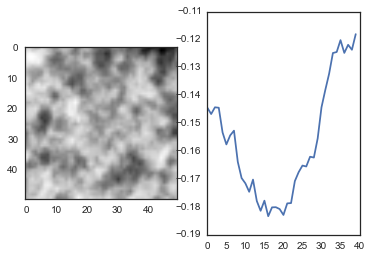

In [179]:
plt.subplot(1,2,1)
plt.imshow(space)
plt.subplot(1,2,2)
plt.plot(time)

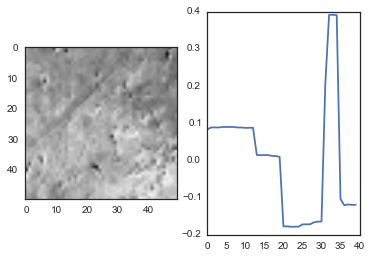

In [162]:
plt.subplot(1,2,1)
plt.imshow(space)
plt.subplot(1,2,2)
plt.plot(time)

In [153]:
L4_sta.shape

(40, 50, 50)

In [131]:
space, time = ft.decompose(L4_sta)

ValueError: On entry to DLASCL parameter number 4 had an illegal value

In [136]:
L4_sta[3]

array([[ -855.30443682,  -593.05609766,  -269.1616246 , ...,
           14.3366435 ,  -831.24601617,  -334.88220402],
       [ -327.45900543,  -148.90790029,   285.57143841, ...,
        -1338.48685679, -1375.61706469,  -575.61276683],
       [ -366.33935193, -1602.13484168,  -466.03114633, ...,
          -30.59461282,   180.77697438,  -752.79222209],
       ..., 
       [-2837.82908685, -2464.43045922, -2374.26029244, ...,
        -1917.4888262 , -1713.09656174, -1772.43408476],
       [-2155.6608695 , -2533.3120432 , -2798.29602961, ...,
        -1352.75806384, -1264.93532363, -1242.17297725],
       [-2772.86449969, -2388.07219724, -4210.14880594, ...,
        -1258.33700033, -1807.25569524, -3349.7586602 ]])

<matplotlib.colorbar.Colorbar instance at 0x142d4a3b0>

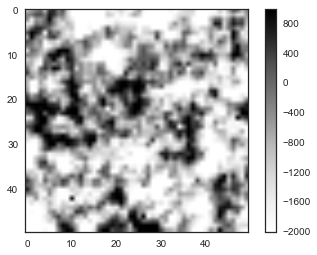

In [138]:
plt.imshow(L4_sta[3], clim=[-2000, 1000])
plt.colorbar()

In [139]:
np.min(L4_sta)

-4.1724137974117294e+307

In [140]:
np.max(L4_sta)

1.2954121787682433e+307

<matplotlib.colorbar.Colorbar instance at 0x15626b8c0>

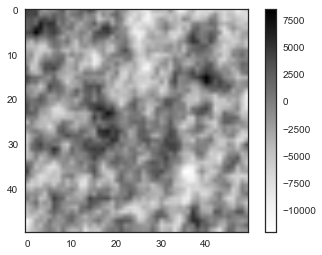

In [184]:
plt.imshow(L4_sta[30])
plt.colorbar()

In [185]:
space, time = ft.decompose(L4_sta)

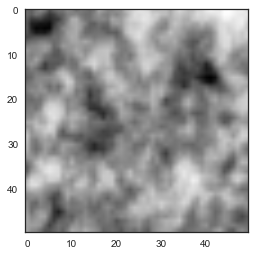

In [186]:
plt.imshow(space)

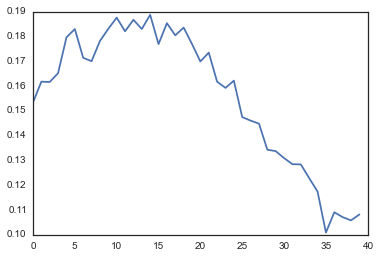

In [187]:
plt.plot(time)